In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%load_ext line_profiler
%matplotlib inline

torch.set_default_tensor_type(torch.DoubleTensor)

import os, sys 
sys.path.append(os.path.abspath(".."))

### Specifying the circuit to simulate

In [15]:
# from examples.mrna_srna.mrna_srna_incis import mRNAsRNAInCis, cfg
# reaction_system = mRNAsRNAInCis()

from examples.mrna_srna.mrna_srna_intrans import mRNAsRNAInTrans, cfg
reaction_system = mRNAsRNAInTrans()

# reaction_system.params = {'beta_fmrna': 2}  # increasing fmRNA production rate


### Simulating the circuit

Simulation parameters

In [23]:
from src.simulators import StochasticSimulator, DeterministicSimulator 
from src.data_class import SimulationData

end_time = 300
n_steps = 300
n_traj = 1000


Parameters for deterministic simulations 

In [24]:
ode_simulator = DeterministicSimulator(
    reaction_system=reaction_system,
    cfg=cfg
)
init_pops = np.zeros((reaction_system.n_species,))
time_grid_np = np.arange(0, end_time, int(end_time / n_steps))
ode_res = ode_simulator.simulate(init_pops=init_pops, time_grid=time_grid_np)

Parameters for stochastic simulations 

In [25]:
init_pops = torch.zeros((reaction_system.n_species, ), dtype=torch.int64) #torch.randint(1, (reaction_system.n_species, ))
time_grid_torch = torch.from_numpy(time_grid_np)

# Specifying a simulator using direct method
cfg['solver'] = 'direct'
data_set_direct = SimulationData()
ssa_simulator_direct = StochasticSimulator(
    reaction_system=reaction_system,
    data_set=data_set_direct,
    cfg=cfg
)
# Specifying a simulator using first reaction method
cfg['solver'] = 'first_reaction'
data_set_fr = SimulationData()
ssa_simulator_fr = StochasticSimulator(
    reaction_system=reaction_system,
    data_set=data_set_fr,
    cfg=cfg
)

Timing simulators 

In [30]:
%timeit ssa_simulator_fr.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)

6.72 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit ssa_simulator_direct.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)

6.74 s ± 344 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Plotting results for verification

Comptuting the statistics on a grid

In [28]:
means_direct = data_set_direct.mean(time_range=time_grid_torch)
stds_direct = data_set_direct.std(time_range=time_grid_torch)
cov_direct = data_set_direct.coefficient_of_variation(time_range=time_grid_torch)

means_fr = data_set_fr.mean(time_range=time_grid_torch)
stds_fr = data_set_fr.std(time_range=time_grid_torch)
cov_fr = data_set_fr.coefficient_of_variation(time_range=time_grid_torch)

Plotting

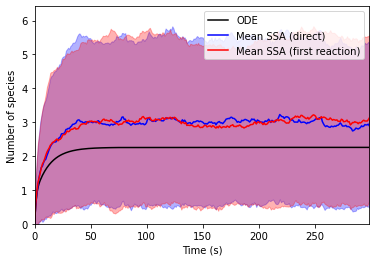

In [29]:
species_idx = 1
plt.figure()
# ode
plt.plot(time_grid_np, ode_res[species_idx, :], 'k', label='ODE')
# direct ssa 
plt.plot(time_grid_torch, means_direct[species_idx, :], 'b', label='Mean SSA (direct)')
plt.fill_between(time_grid_torch, means_direct[species_idx,:]+stds_direct[species_idx, :], means_direct[species_idx,:]-stds_direct[species_idx, :], 
                 color='b', alpha=0.3)
plt.xlim([0, end_time])    

plt.xlabel('Time (s)')
plt.ylabel('Number of species')
# first reaction ssa
plt.plot(time_grid_torch, means_fr[species_idx, :], 'r', label='Mean SSA (first reaction)')
plt.fill_between(time_grid_torch, means_fr[species_idx,:]+stds_fr[species_idx, :], means_fr[species_idx,:]-stds_fr[species_idx, :], 
                 color='r',alpha=0.3)
plt.xlim([0, end_time])    
plt.xlabel('Time (s)')
plt.ylabel('Number of species')
plt.xlim([0, max(time_grid_np)])
plt.ylim([0, 1.1 * max([(means_direct[species_idx,:]+stds_direct[species_idx, :]).max(), 
                        (means_fr[species_idx,:]+stds_fr[species_idx, :]).max()])])
plt.legend()